In [205]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## What Does Derivative Mean ?

In [208]:
def f(x):
    return 3*x**2 -4*x + 5

In [210]:
xs = np.arange(-5,5,0.25)
ys = f(xs)

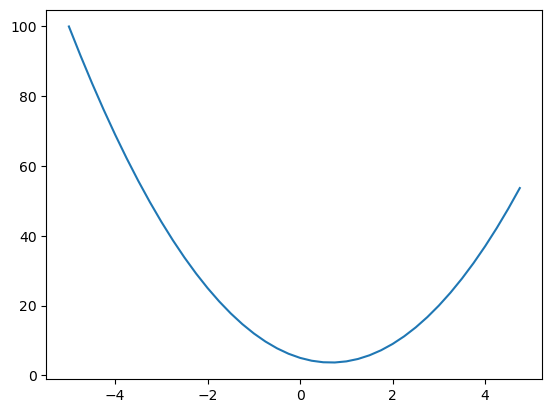

In [212]:
plt.plot(xs,ys)

In [214]:
#Definition of the Derivative Approach
#Use the definition to calculate  derivative 
#As h gets smaller it gets closer to the theoretical result.
h = 0.0000000001
x = 2/3
(f(x+h) - f(x)) / h

0.0

In [216]:
#Lets get more complex
#Try derivatives wrp to other variables
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c+= h
d2 = a*b + c 

print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


## Creating the Data Structues

In [461]:
#One of the main reasons we create a data structure is that
#We will create it so that it will help us to keep track of the variables.
#Using a pointer like system, for each operation like addition or multiplication 
#we will build a add a pointer to it in which the variable that is the result of the 
#operation will point its components. Basically what values produce what other values
#we want to keep track of that.

class Value:

    #The constructor, we only take the value
    #We also take a parameter called (tuple) children
    #Also what operation created those values given in _op
    #Add label to give its labels which can be shown in the graph
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        #The most important feature. It will keep track of the gradient
        self.grad = 0.0
        #The magic function that takes the local gradient and multiply it with next node's gradient
        #For the leaf node it should be none at least in the beginnig
        #It will do its magic based on the operaiton (addition,multiplication,tanh etc)
        self._backward = lambda: None
        #Self._prev keeps track of the variables that produced that variable aka children
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    #String repsentation method, when we call it, it will show its value
    def __repr__(self):
        return f"Value(data={self.data})"

    #To be able to add Value objects we call speacial method __add__
    def __add__(self,other):
        #It says that once called, take your object's value and other and then sum those
        #And create a new Value object with the sum
        #In python a + b works as a.__add__(b) Thus it will work to sum 2 values now in
        #Our objects
        #For operations we also give it to the children parameter so that
        #The new value will have _prev which points to variables that created itself.
        out = Value(self.data + other.data,(self,other),'+')
        #Calculate the gradient for addition

        #Addition makes no changes and transfers it the gradient
        #So the children of the addition operation will take its parent's gradient only == out.grad (result node of the addition)
        #Then multiply it via its local derivative which is 1.
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        

        #Assign the inner defined function as the result node's backward function
        out._backward = _backward
        return out

        #To be able to add Multiply objects we call speacial method __mul__
    def __mul__(self,other):
        #It says that once called, take your object's value and other and then multiply those
        #And create a new Value object with the calculation
        #In python a * b works as a.__mul__(b) Thus it will work to multiply 2 values now in
        #Our objects
        #For operations we also give it to the children parameter so that
        #The new value will have _prev which points to variables that created itself.
        out = Value(self.data * other.data,(self,other),'*')

        #Since in multiplication the local gradient is the multiplicator, we take it like that
        #e.g. y = a1x1  dy/dx1 = a1 and dy/da1 = x1
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
            
        out._backward = _backward
            
        return out

        #For the activation function. The reason we need to implement this is that we will need the derivative of this function
        #So it does not need to be very simple functions we can derive tanh directly no need to derive exponentian and go from there
        #but we need to define it and we need to know its local derivative to be able to use a function
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        #The children will be itself since it does not take 2 inputs and converts but takes one input and converts
        out = Value(t,(self,),"tanh")

        #By definition it is 1 -tanh(x)**2
        def _backward():
            self.grad += (1-t**2)* out.grad

        out._backward = _backward
        
        return out


    #Its logic explained in the Backpropagation Logic Section
    def backward(self):
        #Topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                #It adds it to the list only after all of its children has been added
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

       
        #Initialize the result node's gradient as 1 (self in this case)
        self.grad = 1.0
         #Start from the end (self)build the order
        build_topo(self)
        #Since we need it in the reverse order we will start from end and go back and call all the _backward function
        for node in reversed(topo):
            node._backward()

In [247]:
#Build the above expression now with our Data Structure
a = Value(2.0,label="a")
b = Value(-3.0,label="b")
c = Value(10.0,label="c")
e = a*b; e.label = "e"
d = e + c ; d.label = "d"
f = Value(-2.0,label = "f")
L = d*f ; L.label ="L"
L

Value(data=-8.0)

In [249]:
#Children of d are -6 which comes from a*b
# and 10 which is c
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [251]:
#It is created via + (addition)
d._op

'+'

## Created the Graph Visualization

In [262]:
#This part is taken as in video
#I tried to understand it by following the code, not familiar with graphviz library
#Kind of got it but not fully.
#2 methods which will help us to visualize the mathematical
#expressions.
from graphviz import Digraph

def trace(root):
    # builds the set of all nodes and edges for a graph
    nodes,edges = set(),set()
    #Function in function Alert
    def build(v):
        #If node to be created (it should not be in the list of nodes)
        #
        if v not in nodes:
            #Add it to the nodes set
            nodes.add(v)
            #For every children of a Value object
            for child in v._prev:
                #Add the edges as a tuple which shows which nodes and edges will be connected
                #For every children of a given node
                edges.add((child,v))
                build(child)
    build (root)
    return nodes,edges

def draw_dot(root):
    #Draw from left to right 
    dot = Digraph(format="svg",graph_attr={"rankdir":"LR"}) #LR = left to right
    #Call the trace function to create the nodes and edges (build the graph)
    nodes,edges = trace(root)
    #Draw the nodes as build in the traces method
    for n in nodes:
        #for any value in the graph,create a rectangular ("record") node for it
        #uid is the name of the node
        uid = str(id(n))
        #add those nodes with their names
        #Also show the gradient of output w.r.t. to the value
        dot.node(name = uid,label ="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad ), shape ="record")
        #If it has any children meaning it has some operation
        if n._op:
            #if this value is a result of some operation, create and op node for it
            #Add its children as node
            dot.node(name = uid + n._op,label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op,uid)
    for n1,n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

## Backpropagation Logic

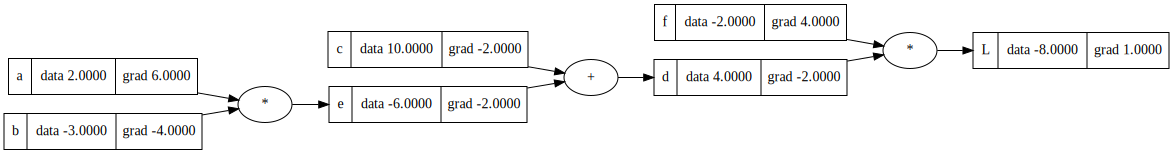

In [288]:
#A nice representation of math expressions.
#Shows which values are created with which and the operation
draw_dot(L)  

In [286]:
#Manual Backpropagation
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
#Since in a simple sum, local derivatives  (dd/dc dd/de) will be one, then by chain rule
#dL / dc = (dL / dd )*  (dd/dc) and dd/dc is one. then dL / dc = dL/dd
#Basically then we can say that summation just routes or transfers the derivative we can think of it as 
#Coming from the back it takes derivate and transfers it to its child nodes as it is.
c.grad = -2.0
e.grad = -2.0
#Since dL /de is calculated by accumulating the gradients again we can simply find
#Coming from the back as we enter the dL / df,dd,dc,de it makes it easier to find the derivative 
#We just need to find the local derivative and multiply it (by the chain rule) to its parent's derivative
#dL / da = ( dL / de ) / (de / da)
a.grad = (-2.0*-3.0)
b.grad = (-2.0*2.0)

In [292]:
#We see that as we in the direction of the derivatives a small step
#The L increases
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a*b; 
d = e + c ; 
L = d*f ; L.label ="L"
L

Value(data=-6.860800000000001)

In [439]:
#A simple neuron example (One neuron only)
#Data 2 input features
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")
#weights w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
#bias of the neuron
#Setted for nice gradient results :d
b = Value(6.8813735870195432,label="b")
#Make the linear combination
x1w1 = x1*w1; x1w1.label = "x1*w1";
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b ; n.label = "n"
#Activation Function tanh
o = n.tanh(); o.label = "o"


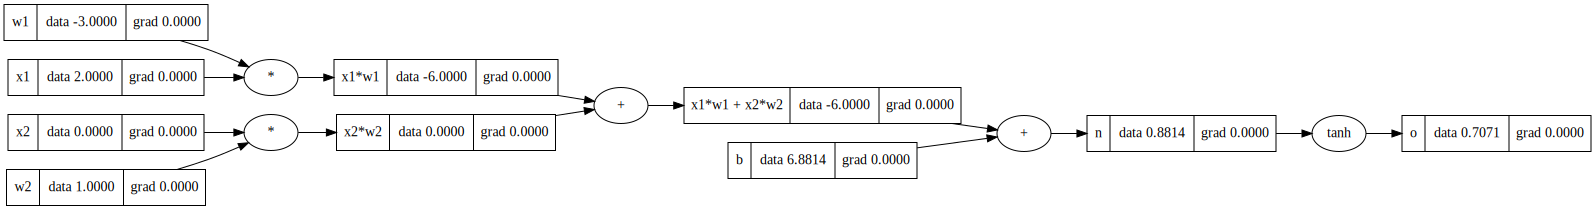

In [394]:
draw_dot(o)

In [358]:
#Manual Back Propagation
o.grad = 1.0
# o = tanh(n)
# do / dn = 1-tanh(n)**2 --wikipedia
# Then tanh(n) = o so, do / dn = 1 - o* *2
print(1-o.data**2)
#Approximately 0.5
n.grad = 0.5
#Sum will flow it back the gradient equally
x1w1x2w2.grad = 0.5
b.grad = 0.5
#Again sum will flow it back
x1w1.grad = 0.5
x2w2.grad = 0.5
#Now the important part -- weights local gradient * next node's gradient (since it flows all the way to the end)
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad
#We see that w2 has gradient 0 and no effect but w1 has gradient 1 and it effects the end result by 1 

0.4999999999999999


In [434]:
#Coded Back Propagation
#Reset the gradients above and check it with the manual calculation

#In default its 0 but we need to make it 1 as in the output node has the derivative by itself is 1
#Initialize
#We need to call backward functions in order
o.grad = 1.0
o._backward()

In [400]:
n._backward()

In [404]:
b._backward()

In [408]:
x1w1x2w2._backward()

In [412]:
x2w2._backward()
x1w1._backward()

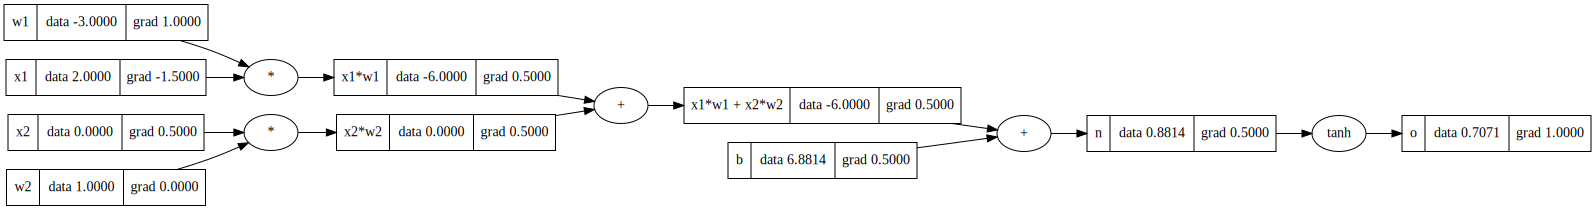

In [414]:
draw_dot(o)


In [416]:
#The thing we should do is now to automate it.
#To do we need to make sure that before a backward function called for a node
#First the previous nodes' backwards should have been called in the right order.
#By doing a topological sort (wikipedia) we can achieve the order of these operations from end to beginning or right to left
#This is graph algorithm I belive, it sorts the node in such a way that ensures the going in one direction.

In [420]:
#Topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        #It adds it to the list only after all of its children has been added
        for child in v._prev:
            build_topo(child)
        topo.append(v)

#Start from o and build the order
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [430]:
#Inialize the result node's gradient as 1.0
o.grad = 1.0

#Topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        #It adds it to the list only after all of its children has been added
        for child in v._prev:
            build_topo(child)
        topo.append(v)

#Start from o build the order
build_topo(o)
#Since we need it in the reverse order we will start from end and go back
for node in reversed(topo):
    node._backward()

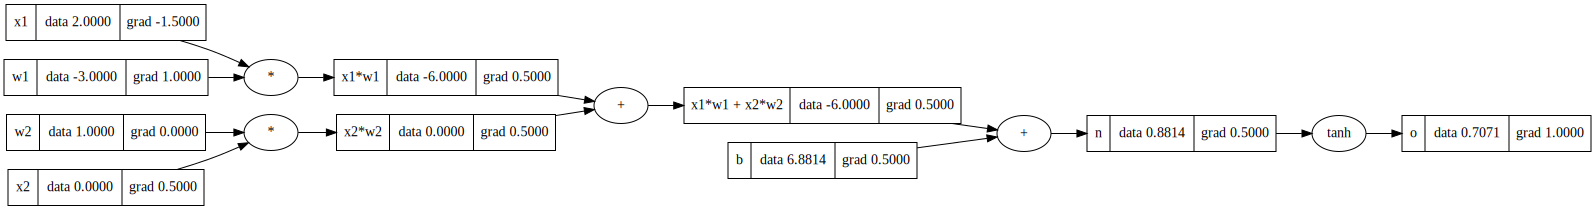

In [432]:
#Reset the gradients above and check
draw_dot(o)

In [451]:
#Reset the gradients above and check!
#Finally call the implement backward method
o.backward()

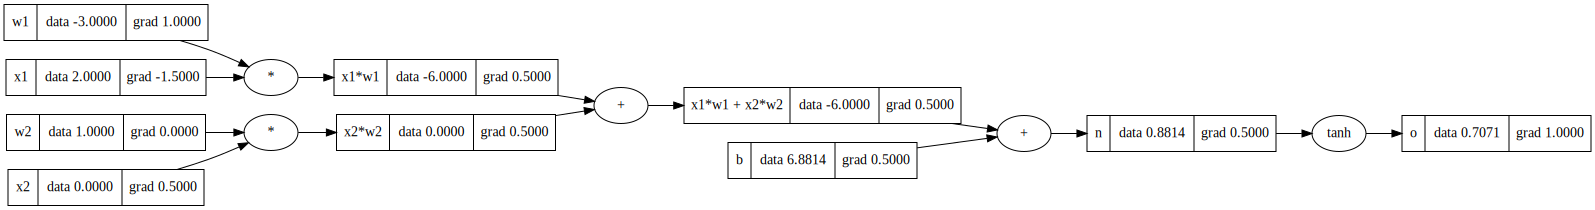

In [449]:
draw_dot(o)

In [463]:
#Final Thing
#If we only calculate the gradient once meaning 
# self.grad = 1.0 * out.grad then we calculate it wrong whenever the same variable used more than one.
#Why because e.g if a = 3 and b = a + a we see the gradient as 1 but it should be 2
#So to prevent this every time a variable is used the gradient should accumulate !! not = but +=
#Solved the bug !!
a = Value(2.0,label="a")
b = a + a ; b.label = "b"
b.backward()

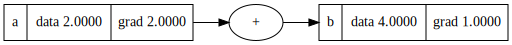

In [465]:
draw_dot(b)